# Classify the tiles using pretrained tile2vec
In this notebook we are going to measure the performance of classifier on EuroSATallbands dataset.

We will use model weights that are in the `/storage/tile2vec/models/`. Firstly we need to load the weights and create the embeddings of the tiles using our pretrained model.

## Load the model

In [1]:
import os
import torch
from pathlib import Path

from src.tilenet import make_tilenet

def load_model(model_filepath):
    model_dir = Path('/storage/tile2vec/models')

    model_fn = model_dir / model_filepath # specify which model weights are to be loaded
    bands = 13 # number of bands in the input data - should matche the model
    z_dim = 512 # output dimension of the last layer of the encoder - should match the model


    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    cuda = torch.cuda.is_available()


    tilenet = make_tilenet(in_channels=bands, z_dim=z_dim) 
    if cuda: 
        tilenet.cuda()

    checkpoint = torch.load(model_fn)
    tilenet.load_state_dict(checkpoint)
    tilenet.eval()
    return tilenet

In [2]:
# load model
import os
import torch
from pathlib import Path

from src.tilenet import make_tilenet
model_dir = Path('/storage/tile2vec/models')

model_fn = model_dir / 'TileNet_default_no_clipping.ckpt' # specify which model weights are to be loaded
bands = 13 # number of bands in the input data - should matche the model
z_dim = 512 # output dimension of the last layer of the encoder - should match the model


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()


tilenet = make_tilenet(in_channels=bands, z_dim=z_dim) 
if cuda: 
    tilenet.cuda()

checkpoint = torch.load(model_fn)
tilenet.load_state_dict(checkpoint)
tilenet.eval()

TileNet(
  (conv1): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,

## load the bare files and organize them into a dataframe



In [9]:

import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from pathlib import Path
from src.data_utils import clip_and_scale_image


In [18]:
val_df = pd.read_csv("/storage/EuroSATallBands/validation.csv")
n_tiles = len(val_df)
tiles_path = Path("/storage/tile2vec/npy/val")

X_bare_val = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_val = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_val[index] = clip_and_scale_image(tile, img_type="sentinel").flatten()
    X_bare_val[index] = tile.flatten()
    
y_val = val_df["Label"]

test_df = pd.read_csv("/storage/EuroSATallBands/test.csv")
n_tiles = len(test_df)
tiles_path = Path("/storage/tile2vec/npy/test")

X_bare_test = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_test = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_test[index] = clip_and_scale_image(tile, img_type="sentinel").flatten()
    X_bare_test[index] = tile.flatten()
    
y_test = test_df["Label"]


train_df = pd.read_csv("/storage/EuroSATallBands/train.csv")
n_tiles = len(train_df)
tiles_path = Path("/storage/tile2vec/npy/train")

X_bare_train = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_train = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_train[index] =  clip_and_scale_image(tile, img_type="sentinel").flatten()

    X_bare_train[index] = tile.flatten()
    
y_train = train_df["Label"]

100%|██████████| 19317/19317 [00:11<00:00, 1746.16it/s]


## create embeddings
Our dataset is already divided into parts - train, validation and test. Therefore we will use the split to train our classifier. We will train the classifier on the validation dataset using crossvalidation. Later, we will measure its performance on the test set to make its behaviour comparable

In [8]:

def create_embeddings_tile2vec(tilenet, df_filepath: str | Path, tiles_path: str | Path, img_type: str = "sentinel"):
    """
    function creates matrix X and y containing embeddings and labels, loads the tiles from directory `tiles_path`
    """
    df_filepath = Path(df_filepath)
    tiles_path = Path(tiles_path)
    df = pd.read_csv(df_filepath)
    n_tiles = len(df)    
    
    X = np.zeros((n_tiles, z_dim))
    
    t0 = time()
    # this solution to iterate over examples is very suboptimal, one should use torch dataset
    for index in tqdm(range(n_tiles)):
        # read the tile from provided filepath
        
        tile = np.load(tiles_path / f"{index}.npy")  
        tile = clip_and_scale_image(tile, img_type=img_type)
        tile = torch.from_numpy(tile).float()
        tile = (tile)
        if cuda: 
            tile = tile.cuda()
        z = tilenet.encode(tile)
        if cuda: 
            z = z.cpu()
        z = z.data.numpy()
        
        X[index,:] = z

    t1 = time()
    print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))
    
    y = df['Label'].values
    
    return X, y   
    

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()

Text(0.5, 1.0, 'Heatmap of predictions')

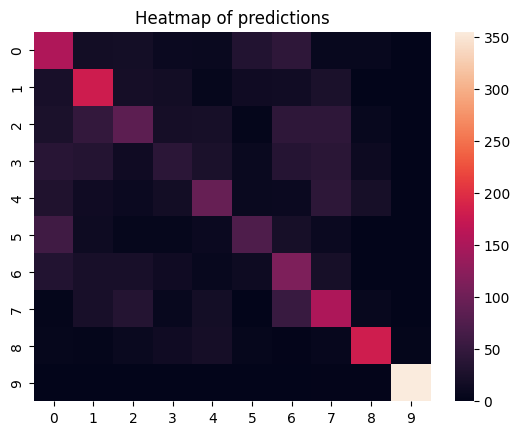

In [26]:
def compare_results(X, y, model, folds = 5, model_name = ""):
    if model_name == "":
        model_name = model.__class__.__name__
    
    scores = cross_val_score(rf, X, y, cv=folds)
    print("Averaged accuracy for model {}: {:.2f}±{:.2f}%".format(model_name, scores.mean()*100, scores.std()*100))

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()


## No band normalization
Here we are going to check the performance of model with no band normalization

In [33]:
no_normalization = load_model("TileNet_simple.ckpt")
X_validation, y_validation = create_embeddings_tile2vec(no_normalization, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', "landsat")
X_test, y_test = create_embeddings_tile2vec(no_normalization, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test', "landsat")

100%|██████████| 5519/5519 [00:18<00:00, 297.81it/s]


Embedded 5519 tiles: 18.535s


100%|██████████| 2759/2759 [00:08<00:00, 310.82it/s]

Embedded 2759 tiles: 8.879s


In [34]:
X = np.concatenate((X_validation, X_test), axis=0)  
y = np.concatenate((y_validation, y_test), axis=0)

In [35]:
compare_results(X, y, rf, folds = 5)

Averaged accuracy for model RandomForestClassifier: 51.53±0.87%


In [36]:
compare_results(X, y, lr, folds = 5)

Averaged accuracy for model LogisticRegression: 51.74±0.85%


In [ ]:
rf.fit(X_validation, y_validation)
y_pred = rf.predict(X_test)


sns.heatmap(confusion_matrix(y_test, y_pred))
plt.title("Heatmap of predictions")

## Custom outlier clipping
Here we evaluate performance of model with band normalization based on IQR on train set

In [37]:
custom_clipping = load_model("TileNet_custom_clipping.ckpt")
X_validation, y_validation = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val')
X_test, y_test = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test')

X = np.concatenate((X_validation, X_test), axis=0)
y = np.concatenate((y_validation, y_test), axis=0)

compare_results(X, y, rf, folds = 5)
compare_results(X, y, lr, folds = 5)

100%|██████████| 5519/5519 [00:20<00:00, 268.68it/s]


Embedded 5519 tiles: 20.544s


100%|██████████| 2759/2759 [00:09<00:00, 278.97it/s]


Embedded 2759 tiles: 9.892s
Averaged accuracy for model RandomForestClassifier: 52.02±0.85%
Averaged accuracy for model LogisticRegression: 51.87±1.04%


In [ ]:
rf.fit(X_validation, y_validation)
y_pred = rf.predict(X_test)


sns.heatmap(confusion_matrix(y_test, y_pred))
plt.title("Heatmap of predictions")

## PCA 
Instead of some fancy tilenet base encoding we will try to use pca to create embeddings

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=512)

pca.fit(X_norm_train)

PCA(n_components=512)

In [23]:
X_norm_valtest = np.concatenate((X_norm_val, X_norm_test), axis=0)
y_valtest = np.concatenate((y_validation, y_test), axis=0)

In [24]:
X_pca = pca.transform(X_norm_valtest)

In [33]:
compare_results(X_pca, y_valtest, rf, folds = 5)
compare_results(X_pca, y_valtest, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 73.33±0.78%
Averaged accuracy for model LogisticRegression: 74.23±0.59%


## FastICA

In [36]:
from sklearn.decomposition import FastICA

fastica = FastICA(n_components=512)

fastica.fit(X_norm_train)

## KMeans

KMeans with 10 clusters

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10)

kmeans.fit(X_norm_train, y_train)

X_kmeans = kmeans.transform(X_norm_valtest)

In [35]:
compare_results(X_kmeans, y_valtest, rf, folds = 5)
compare_results(X_kmeans, y_valtest, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 75.15±0.82%
Averaged accuracy for model LogisticRegression: 75.19±0.68%
